In [1]:
from keras.applications import VGG16
from keras.applications import imagenet_utils
from keras.preprocessing.image import img_to_array
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import LabelBinarizer
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import SGD
from keras.optimizers import RMSprop
from keras.layers import Input
from keras.models import Model
from keras.layers.core import Dense
from keras.layers.core import Dropout
from keras.layers.core import Flatten
from tqdm import tqdm
import cv2
import numpy as np
import random
import os

In [2]:
TRAIN_DIR = "/media/nguyen/6ABE943DBE94042B/Project I - Computer Vision/train"
TEST_DIR = "/media/nguyen/6ABE943DBE94042B/Project I - Computer Vision/test"
IMG_SIZE = 128
LR = 1e-3

MODEL_NAME = f"dogsvscats-{LR}-2conv-basic.model"

In [3]:
image_path = list(os.listdir(TRAIN_DIR))
random.shuffle(image_path)


In [4]:
labels = [p.split('.')[-3] for p in image_path]


In [5]:
le = LabelEncoder()
labels = le.fit_transform(labels)
labels

array([1, 0, 0, ..., 0, 0, 1])

In [6]:
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels

array([[1],
       [0],
       [0],
       ...,
       [0],
       [0],
       [1]])

In [11]:
# list_image = []
# for imagePath in tqdm(image_path):
#     path = os.path.join(TRAIN_DIR,imagePath)
#     image = cv2.imread(path)
#     image = cv2.resize(image, (128,128))
#     image = np.array(image)
#     # bien thanh numpy.array 3d
#     image = np.expand_dims(image, 0)
#     # xu li lai du lieu anh
#     image = imagenet_utils.preprocess_input(image)
#     list_image.append(image)
# list_image = np.vstack(list_image)
# # np.save("list_image.npy", list_image)
list_image = np.load("list_image.npy")

In [9]:
# Keras works with batches of images. So, the first dimension is used for the number of samples (or images) you have.

# When you load a single image, you get the shape of one image, which is (size1,size2,channels).

# In order to create a batch of images, you need an additional dimension: (samples, size1,size2,channels)

# The preprocess_input function is meant to adequate your image to the format the model requires.

In [10]:
# This loads an image and resizes the image to (224, 224):

#  img = image.load_img(img_path, target_size=(224, 224))
# The img_to_array() function adds channels: x.shape = (224, 224, 3) for RGB and (224, 224, 1) for gray image

#  x = image.img_to_array(img) 
# expand_dims() is used to add the number of images: x.shape = (1, 224, 224, 3):

# x = np.expand_dims(x, axis=0)
# preprocess_input subtracts the mean RGB channels of the imagenet dataset. This is because the model you are using has been trained on a different dataset: x.shape is still (1, 224, 224, 3)

# x = preprocess_input(x)
# If you add x to an array images, at the end of the loop, you need to add images = np.vstack(images) so that you get (n, 224, 224, 3) as the dim of images where n is the number of images processed

In [13]:
list_image.shape

(25000, 128, 128, 3)

In [14]:
X_train, y_train = list_image[:20000], labels[:20000]
X_test, y_test = list_image[20000:25000], labels[20000:25000]

In [15]:
aug_train = ImageDataGenerator(rescale=1./255, rotation_range=30,
    width_shift_range=0.1, height_shift_range=0.1, shear_range=0.2,
    zoom_range=0.2, horizontal_flip=True,
    fill_mode='nearest')
aug_test= ImageDataGenerator(rescale=1./255)

In [16]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

In [18]:
pretrained_base = VGG16(weights='imagenet', include_top=False,
    input_tensor=Input(shape=(128, 128, 3)))
pretrained_base.trainable = False

58892288/58889256 [==============================] - 5s 0us/step


In [20]:
model = keras.Sequential([
    # Base
    pretrained_base,
    # Head
    layers.Flatten(),
    layers.Dense(1, activation='sigmoid'),
])

In [22]:
opt = 'adam'
model.compile(opt, 'binary_crossentropy', ['binary_accuracy'])
numOfEpoch = 25
H = model.fit_generator(aug_train.flow(X_train, y_train, batch_size=64),
    steps_per_epoch=34,
    validation_data=(aug_test.flow(X_test, y_test,
    batch_size=64)),
    validation_steps=34,
    epochs=numOfEpoch)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/25
34/34 [==============================] - 227s 7s/step - loss: 0.5458 - binary_accuracy: 0.7229 - val_loss: 0.3817 - val_binary_accuracy: 0.8300
Epoch 2/25
34/34 [==============================] - 219s 6s/step - loss: 0.4088 - binary_accuracy: 0.8157 - val_loss: 0.3209 - val_binary_accuracy: 0.8676
Epoch 3/25
34/34 [==============================] - 208s 6s/step - loss: 0.3746 - binary_accuracy: 0.8274 - val_loss: 0.2943 - val_binary_accuracy: 0.8750
Epoch 4/25
34/34 [==============================] - 213s 6s/step - loss: 0.3541 - binary_accuracy: 0.8433 - val_loss: 0.3112 - val_binary_accuracy: 0.8713
Epoch 5/25
34/34 [==============================] - 223s 7s/step - loss: 0.3353 - binary_accuracy: 0.8506 - val_loss: 0.2507 - val_binary_accuracy: 0.8980
Epoch 6/25
34/34 [==============================] - 208s 6s/step - loss: 0.3127 - binary_accuracy: 0.8635 - val_loss: 0.2886 - val_binary_accuracy: 0

In [23]:
model.save("Cat_Dog_VGG16_FeaturesTransfer")

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: Cat_Dog_VGG16_FeaturesTransfer/assets


In [27]:
import tensorflow as tf
import datetime

ValueError: in user code:

    /home/nguyen/anaconda3/envs/Cat_Dog/lib/python3.6/site-packages/tensorflow/python/keras/engine/training.py:1147 predict_function  *
        outputs = self.distribute_strategy.run(
    /home/nguyen/anaconda3/envs/Cat_Dog/lib/python3.6/site-packages/tensorflow/python/distribute/distribute_lib.py:951 run  **
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /home/nguyen/anaconda3/envs/Cat_Dog/lib/python3.6/site-packages/tensorflow/python/distribute/distribute_lib.py:2290 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /home/nguyen/anaconda3/envs/Cat_Dog/lib/python3.6/site-packages/tensorflow/python/distribute/distribute_lib.py:2649 _call_for_each_replica
        return fn(*args, **kwargs)
    /home/nguyen/anaconda3/envs/Cat_Dog/lib/python3.6/site-packages/tensorflow/python/keras/engine/training.py:1122 predict_step  **
        return self(x, training=False)
    /home/nguyen/anaconda3/envs/Cat_Dog/lib/python3.6/site-packages/tensorflow/python/keras/engine/base_layer.py:927 __call__
        outputs = call_fn(cast_inputs, *args, **kwargs)
    /home/nguyen/anaconda3/envs/Cat_Dog/lib/python3.6/site-packages/tensorflow/python/keras/engine/sequential.py:277 call
        return super(Sequential, self).call(inputs, training=training, mask=mask)
    /home/nguyen/anaconda3/envs/Cat_Dog/lib/python3.6/site-packages/tensorflow/python/keras/engine/network.py:719 call
        convert_kwargs_to_constants=base_layer_utils.call_context().saving)
    /home/nguyen/anaconda3/envs/Cat_Dog/lib/python3.6/site-packages/tensorflow/python/keras/engine/network.py:888 _run_internal_graph
        output_tensors = layer(computed_tensors, **kwargs)
    /home/nguyen/anaconda3/envs/Cat_Dog/lib/python3.6/site-packages/tensorflow/python/keras/engine/base_layer.py:927 __call__
        outputs = call_fn(cast_inputs, *args, **kwargs)
    /home/nguyen/anaconda3/envs/Cat_Dog/lib/python3.6/site-packages/tensorflow/python/keras/engine/network.py:719 call
        convert_kwargs_to_constants=base_layer_utils.call_context().saving)
    /home/nguyen/anaconda3/envs/Cat_Dog/lib/python3.6/site-packages/tensorflow/python/keras/engine/network.py:888 _run_internal_graph
        output_tensors = layer(computed_tensors, **kwargs)
    /home/nguyen/anaconda3/envs/Cat_Dog/lib/python3.6/site-packages/tensorflow/python/keras/engine/base_layer.py:886 __call__
        self.name)
    /home/nguyen/anaconda3/envs/Cat_Dog/lib/python3.6/site-packages/tensorflow/python/keras/engine/input_spec.py:180 assert_input_compatibility
        str(x.shape.as_list()))

    ValueError: Input 0 of layer block1_conv1 is incompatible with the layer: expected ndim=4, found ndim=3. Full shape received: [32, 128, 1]


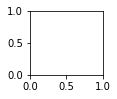

In [37]:
import matplotlib.pyplot as plt

# if you need to create the data:
#test_data = process_test_data()
# if you already have some saved:
test_data = np.load('test_data.npy',allow_pickle=True)

fig=plt.figure()

for num,data in enumerate(test_data[:12]):
    # cat: [1,0]
    # dog: [0,1]
    
    img_num = data[1]
    img_data = data[0]
    
    y = fig.add_subplot(3,4,num+1)
    orig = img_data
    data = img_data.reshape(IMG_SIZE,IMG_SIZE,1)
    #model_out = model.predict([data])[0]
    model_out = model.predict([data])[0]
    
    if np.argmax(model_out) == 1: str_label='Dog'
    else: str_label='Cat'
        
    y.imshow(orig,cmap='gray')
    plt.title(str_label)
    y.axes.get_xaxis().set_visible(False)
    y.axes.get_yaxis().set_visible(False)
plt.show()

In [36]:
img_data.shape

(50, 50)

In [24]:
from tensorflow import keras
from tensorflow.keras import layers
# these are a new feature in TF 2.2
from tensorflow.keras.layers.experimental import preprocessing

In [25]:
pretrained_base = VGG16(weights='imagenet', include_top=False,
input_tensor=Input(shape=(128, 128, 3)))

SyntaxError: invalid character in identifier (<ipython-input-25-00373405bf67>, line 1)

In [ ]:
model = keras.Sequential([
# Base
    pretrained_base,
# Head
    layers.Flatten(),
#add convulational
    layers.Dense(256, activation = 'relu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid'),
])

In [ ]:
for layer in pretrained_base.layers:
    layer.trainable = False
opt = RMSprop(0.001)
#opt = ’adam’
model.compile(opt, 'binary_crossentropy', ['binary_accuracy'])
numOfEpoch = 25
H = model.fit_generator(aug_train.flow(X_train, y_train, batch_size=64),
    steps_per_epoch=34,
    validation_data=(aug_test.flow(X_test, y_test,
    batch_size=64)),
    validation_steps=34,
    epochs=numOfEpoch)

In [ ]:
model.save("Cat_Dog_VGG16_FineTuning")

In [12]:
def label_img(img):
    word_label = img.split('.')[-3]
    # conversion to one-hot array [cat,dog]
    #                            [much cat, no dog]
    if word_label == 'cat': return [1,0]
    #                             [no cat, very doggo]
    elif word_label == 'dog': return [0,1]


In [13]:
def create_train_data():
    training_data = []
    for img in tqdm(os.listdir(TRAIN_DIR)):
        label = label_img(img)
        path = os.path.join(TRAIN_DIR,img)
        img = cv2.imread(path,cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, (IMG_SIZE,IMG_SIZE))
        training_data.append([np.array(img),np.array(label)])
    shuffle(training_data)
    np.save('train_data.npy', training_data)
    return training_data

In [14]:
def process_test_data():
    testing_data = []
    for img in tqdm(os.listdir(TEST_DIR)):
        path = os.path.join(TEST_DIR,img)
        img_num = img.split('.')[0]
        img = cv2.imread(path,cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, (IMG_SIZE,IMG_SIZE))
        testing_data.append([np.array(img), img_num])
        
    shuffle(testing_data)
    np.save('test_data.npy', testing_data)
    return testing_data

In [15]:
#train_data = create_train_data()
# If you have already created the dataset:
#/home/nguyen/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:136
train_data = np.load('/media/nguyen/6ABE943DBE94042B/Project I - Computer Vision/train_data.npy',allow_pickle=True)
train_data

array([[array([[ 42,   1,   1, ..., 148, 144, 142],
       [ 37,   1,   1, ..., 147, 147, 144],
       [ 42,   3,   2, ..., 149, 146, 141],
       ...,
       [116, 132, 122, ..., 199, 204, 212],
       [108, 106, 110, ..., 216, 219, 220],
       [ 64,  92, 101, ..., 228, 184, 210]], dtype=uint8),
        array([1, 0])],
       [array([[58, 71, 68, ..., 39, 32, 33],
       [56, 62, 65, ..., 40, 35, 37],
       [58, 61, 66, ..., 34, 35, 36],
       ...,
       [11, 11, 10, ..., 57, 57, 59],
       [ 9,  8,  9, ..., 62, 64, 64],
       [12,  8,  7, ..., 72, 67, 67]], dtype=uint8),
        array([0, 1])],
       [array([[ 63,  69,  76, ...,  45,  43,  65],
       [ 86,  76,  74, ...,  79,  72,  53],
       [ 91, 105,  91, ...,  79,  73,  74],
       ...,
       [134, 129, 128, ..., 105, 102, 113],
       [123, 123, 134, ..., 103, 108, 103],
       [120, 122, 126, ..., 105, 104, 104]], dtype=uint8),
        array([1, 0])],
       ...,
       [array([[178, 116, 113, ..., 169, 142, 145],
   

In [16]:
import tflearn
from tflearn.layers.conv import conv_2d, max_pool_2d
from tflearn.layers.core import input_data, dropout, fully_connected
from tflearn.layers.estimator import regression

# Real-time data augmentation
img_aug = tflearn.ImageAugmentation()
# Random flip an image
img_aug.add_random_flip_leftright()
# Random rotate an image
img_aug.add_random_rotation()


# Add these methods into an 'input_data' layer
convnet = input_data(shape=[None, IMG_SIZE, IMG_SIZE, 1],
                     data_augmentation=img_aug,
                     name = 'input')


convnet = conv_2d(convnet, 32, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)

convnet = conv_2d(convnet, 64, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)

convnet = conv_2d(convnet, 128, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)

convnet = conv_2d(convnet, 64, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)

convnet = conv_2d(convnet, 32, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)

convnet = fully_connected(convnet, 1024, activation='relu')
convnet = dropout(convnet, 0.8)

convnet = fully_connected(convnet, 2, activation='softmax')
convnet = regression(convnet, optimizer='adam', learning_rate=LR, loss='categorical_crossentropy', name='targets')

model = tflearn.DNN(convnet, tensorboard_dir='log')

ModuleNotFoundError: No module named 'tflearn'

In [ ]:
if os.path.exists('{}.meta'.format(MODEL_NAME)):
    model.load(MODEL_NAME)
    print('model loaded!')

In [ ]:
train = train_data[:-500]
test = train_data[-500:]

In [ ]:
X = np.array([i[0] for i in train]).reshape(-1,IMG_SIZE,IMG_SIZE,1)
Y = [i[1] for i in train]

x_val = np.array([i[0] for i in test]).reshape(-1,IMG_SIZE,IMG_SIZE,1)
y_val = [i[1] for i in test]

In [ ]:
model.fit({'input': X}, {'targets': Y}, n_epoch=10, validation_set=({'input': x_val}, {'targets': y_val}), 
    snapshot_step=500, show_metric=True, run_id=MODEL_NAME)

In [ ]:
!tensorboard --logdir="/media/nguyen/6ABE943DBE94042B/Project I - Computer Vision/log"

In [ ]:
# transform_data.show(1)

In [ ]:
# # Real-time data augmentation
# img_aug = tflearn.ImageAugmentation()
# # Random flip an image
# img_aug.add_random_flip_leftright()
# # Random rotate an image
# img_aug.add_random_rotation()


# # Add these methods into an 'input_data' layer
# convnet = input_data(shape=[None, IMG_SIZE, IMG_SIZE, 1],
#                      data_augmentation=img_aug,
#                      name = 'input')

In [ ]:
process_test_data()

In [ ]:
import matplotlib.pyplot as plt

# if you need to create the data:
#test_data = process_test_data()
# if you already have some saved:
test_data = np.load('test_data.npy')

fig=plt.figure()

for num,data in enumerate(test_data[:12]):
    # cat: [1,0]
    # dog: [0,1]
    
    img_num = data[1]
    img_data = data[0]
    
    y = fig.add_subplot(3,4,num+1)
    orig = img_data
    data = img_data.reshape(IMG_SIZE,IMG_SIZE,1)
    #model_out = model.predict([data])[0]
    model_out = model.predict([data])[0]
    
    if np.argmax(model_out) == 1: str_label='Dog'
    else: str_label='Cat'
        
    y.imshow(orig,cmap='gray')
    plt.title(str_label)
    y.axes.get_xaxis().set_visible(False)
    y.axes.get_yaxis().set_visible(False)
plt.show()